In [343]:
#Extended Kalman Filter Code Prototype for 1D use on EXCLAIM Project with multiple position sensors whose time rates are different, code by Joaquin Matticoli

In [344]:
import numpy as np
from numpy import dot
import filterpy
from filterpy.kalman import ExtendedKalmanFilter as ekf
from filterpy.kalman import update
from numpy.random import randn
#from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
#import filterpy.stats as stats
import math
from math import sqrt
import cmath
import decimal
from decimal import *

In [345]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(t, predict, update, z1, z2, K): # Prediction + Sensor 1 and 2
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '   {:.3f}    {:.3f}     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z1, z2, update[0], update[1], K))
    
def print_gh1(t, predict, update, z1, K): # Prediction + Sensor 1 only
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '   {:.3f}    -----     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z1, update[0], update[1], K))
    
def print_gh2(t, predict, update, z2, K): # Prediction + Sensor 2 only
    predict_template = '{:.3f}    {:.3f}    {:.3f}'
    update_template = '   -----    {:.3f}     {:.3f}     {:.3f}    {:.3f}'

    print(predict_template.format(t, predict[0], predict[1]),end=' ')
    print(update_template.format(z2, update[0], update[1], K))

In [346]:
class PendulumPayloadSimulation(object): #Pendulum example, no torque because it would be too hard to calculate
    def __init__(self, x0=0., measurement1_var=0.0, 
                 measurement2_var=0.0, process_var=0.0,
                 t_0=0., amp=1.0, freq=1.0, phase=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (rad/s)^2
        """
        self.x = x0
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)
        self.amp = math.radians(amp)
        self.freq = math.radians(freq)
        self.phase = math.radians(phase)

    def move(self, dt):
        """Compute new orientation of the payload in radians."""
        t = t_0 + dt
        self.x = self.amp*math.sin((self.freq*t-self.phase)) + randn()*self.process_std
        self.xdot = self.freq*self.amp*math.cos((self.freq*t-self.phase)) + randn()*self.process_std

    def sense_position(self):
        """ Returns measurement of new orientation in radians."""
        measurement = self.x + randn()*self.meas1_std
        return measurement
    
    def sense_velocity(self):
        """ Returns measurement of new angular velocity in radians/sec."""
        measurement2 = self.xdot + randn()*self.meas2_std
        return measurement2

    def move_and_sense(self, dt=1.0):
        """ Move payload, and return measurement of new orientation in radians"""
        self.move(dt=dt)
        return self.sense_position()

In [347]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

# -----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 1 #number of sensors used
process_var = math.radians(5.) # variance in the payload's movement, idk what number is good for this??
sensor1_var = math.radians(2.) # variance in the position sensor (magnetometer)
sensor2_var = math.radians(0.5) # variance in velocity sensor (gyroscope)
x = gaussian(math.radians(0.), math.radians(100.))  # payload's initial orientation in rad
spectral_density = 3e-6 #Spectral density of the measurement noise, number taken from Giuseppe for gyro
dt1 = 0.5 # time step in seconds for first sensor
dt2 = 0.3 # time step in seconds for second sensor
torque = 10 #N*m

initial_angular_velocity = 0. # initial angular velocity in rad/s???
total_time = 10. # Total time passed from beginning to end of experiment
t = 0. #initial time in seconds
amplitude = 30 # max theta, degrees
frequency = 1 # angular frequency, deg/s
phase_angle = 0 # degrees

# -----------USER INPUT ENDS--------------------------------

# I = 3900 # Moment of inertia around azimuth for mission in kg * m^2
L = 0.5 # meters
m = 1 # kg
g = 9.807 # m/s
# process_model = gaussian(angular_velocity, process_var) # displacement to add to x
t_0 = t
smallest_time = min(dt1, dt2) #The smaller time increment
n_iter = math.floor(total_time/smallest_time)
dt = smallest_time #initialize dt, will be modified constantly in later equations
    
# simulate payload and get measurements
payload = PendulumPayloadSimulation(
    x0=x.mean,
    measurement1_var=sensor1_var, 
    measurement2_var=sensor2_var,
    process_var=process_var,
    t_0=t,
    amp=amplitude,
    freq=frequency,
    phase=phase_angle)

# creates list of measurements, NOTE: modify this section if measurements are provided
def remain(x1, x2): #produces correct remainder
    w = Decimal(str(x1))
    q = Decimal(str(x2))
    ans =  w % q
    return float(ans)
zs, zs2, ztrue = [], [], []
check = 0
while t <= total_time:
    t = round(t,1)
    r1 = remain(t, dt1)
    r2 = remain(t, dt2)
#     print(t)
    if r1 == 0. and r2 == 0.: #takes measurment of both sensors but only moves once
        zs.append(payload.move_and_sense(dt=dt1))
        zs2.append(payload.sense_velocity())
#         print('Here! Time is: %.2f' % t) #check
        t = t + smallest_time
    elif r1 < smallest_time and check == 0: #Sensor 1 is taking a measurement
        t = t - r1
        zs.append(payload.move_and_sense(dt=dt1))
#         print('Here1 Time is: %.2f' % t) #check
        t = t + r1
        check = 1
    else: #Sensor 2 is taking a measurement
        zs2.append(payload.sense_velocity())
#         print('Here2 Time is: %.2f' % t) #check
        t = t + smallest_time
        check = 0
    ztrue.append(payload.x) #Is this right for the nonlinear filter???
finalposition = payload.x

def HJacobian(x): #Calculates derivative of H, not necessary for ours?
    return f.H
    
def Hx(x): #Our measurements are linear(?) so we don't need this
    return np.dot(f.H,f.x)


def ff(check, x1=0., x2=0.):
#     ff = np.array([[x[1,0], [((-g/L)*cmath.sin(x[0,0]))+B*u]]) #f.f, true for pendulum
#     ff = np.array([[x2, [((-g/L)*cmath.sin(x1))+B*u]]) #f.f, true for pendulum, same as above
    ff1 = x2
    ff2 = ((-g/L)*cmath.sin(x1))+B*u
    if (check == 1):
        return ff1
    elif (check == 2):
        return ff2
    elif (check == 3): # For calculating x in predict state
        return np.array([[x2],[((-g/L)*math.sin(x1))+B*u]])

def FJacobian(x): #Calculates derivative of F (ff) using complex-step method, NOTE: try to generalize for different size matrices
    h = 10**(-7) #recommended value for step size by Giuseppe Cataldo
    x0regular = complex(x[0,0],0)
    x0imaginary = complex(x[0,0],h)
    x1regular = complex(x[1,0],0)
    x1imaginary = complex(x[1,0],h)
    Fjacob = np.zeros((2,2))
    Fjacob11 = ff(check = 1, x2 = x1regular)/h
    Fjacob12 = ff(check = 1, x2 = x1imaginary)/h
    Fjacob21 = ff(check = 2, x1 = x0imaginary)/h
    Fjacob22 = ff(check = 2, x2 = x0regular)/h
    Fjacob[0,0] = Fjacob11.imag
    Fjacob[0,1] = Fjacob12.imag
    Fjacob[1,0] = Fjacob21.imag
    Fjacob[1,1] = Fjacob22.imag
    return Fjacob

PREDICT                        UPDATE
  t        x       var       z1       z2        x       var       K
0.000    0.000    0.002    0.338    -0.311     0.014     0.001    0.000
0.300    -0.310    0.009    -----    -0.318     -0.310     0.009    0.000
0.500    0.295    0.009    -0.365    -----     0.164     0.007    0.198
0.600    45.990    3.044    -----    0.024     45.990     3.044    0.000
0.900    0.148    0.009    -----    0.196     0.148     0.009    0.000
1.000    0.197    0.009    0.385    -----     0.235     0.007    0.200
1.200    37.112    3.273    -----    0.577     37.112     3.273    0.000
1.500    0.696    0.009    0.134    0.359     0.584     0.007    0.000
1.800    0.360    0.009    -----    0.276     0.360     0.009    0.000
2.000    0.410    0.009    0.262    -----     0.381     0.007    0.199
2.100    33.097    2.941    -----    -0.256     33.097     2.941    0.000
2.400    -0.131    0.009    -----    -0.392     -0.131     0.009    0.000
2.500    -0.379    0.009   

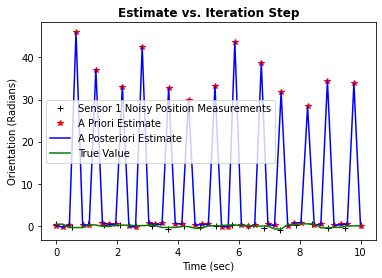

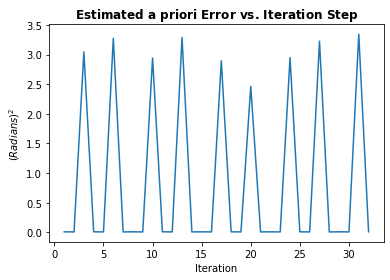

In [348]:
def plotstuff():
    plt.figure()
    plt.plot(np.linspace(0,total_time,len(zs)),zs,'k+',label='Sensor 1 Noisy Position Measurements')
#     plt.plot(np.linspace(0,total_time,len(zs2)),zs2,'r*',label='Sensor 2 Noisy Velocity Measurements')
    plt.plot(np.linspace(0,total_time,len(xprior)),xprior,'r*',label='A Priori Estimate')
    plt.plot(np.linspace(0,total_time,len(xhat)),xhat,'b-',label='A Posteriori Estimate')
    plt.plot(np.linspace(0,total_time,len(ztrue)),ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Time (sec)')
    plt.ylabel('Orientation (Radians)')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Phat not valid at step 0
    plt.plot(valid_iter,Phat[1:n_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Radians)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

Phat = [] #Variance after update
xhat = [] #Estimate after update
xprior = [] #Prediction before update
counter = 0
if printcase == 1:
    print('PREDICT                        UPDATE')
    print('  t        x       var       z1       z2        x       var       K')

# perform Kalman filter on measurements zs1 and zs2
f = ekf(dim_x=number_of_variables, dim_z=number_of_sensors)
u = torque
B = 1/(m*L**2)
# ff = np.array([[f.x[1,0]], [((-g/L)*math.sin(f.x[0,0]))+B*u]]) #f.f, true for pendulum
#f.F =  np.array([[0,1],[(-g/L)math.cos(f.x[0,0]),0]]) # Jacobian of f.f, should be approximately equal to what is calculated in complex-step method
f.x = np.array([[x.mean], [initial_angular_velocity]])
f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                 [(dt**2)/2,  dt      ]]) *spectral_density
f.P = np.diag([x.var,process_var*math.pi/180]) #Variance

counter1 = 0
counter2 = 0
t = t_0
t_old = t_0
check = 0
# print('dt1 = %.2f' % dt1, '   dt2 = %.2f' % dt2) # Check
while t <= total_time:
    t = round(t,1)
    r1 = remain(t, dt1)
    r2 = remain(t, dt2)
#     print(t)
    if r1 == 0. and r2 == 0.: #Both sensors are taking measurements, perform two updates, one with each sensor is this right?????????????????
        dt = t - t_old
        f.F = FJacobian(f.x) # Jacobian of f.f calculated with complex method
#         print(f.x) #check
#         print(f.F) #check
#         print()
#         print('t = %.2f Both Sensors' %t)
#         print()
        f.x = ff(check=3, x1=f.x[0,0], x2=f.x[1,0]) # Calculating x as part of predict step
        f.P = dot(f.F, f.P).dot(f.F.T) + f.Q # Caluclating P as part of predict step
        x_prior = np.copy(f.x)
        P_prior = np.copy(f.P)
        f.R[0,0] = sensor1_var #Taking average of variances
        f.H = np.array([[1., 0.]])
        f.update(zs[counter1], HJacobian, Hx)
        f.R[0,0] = sensor2_var
        f.H = np.array([[0., 1.]])
        f.update(zs2[counter2], HJacobian, Hx)
#         print('time: %.2f ' % t, 'r1 = %.2f' % r1, 'r2 = %.2f' % r2, 'both match!')
        t_old = t
        t = t + smallest_time
        prior = gaussian(x_prior[0,0], P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh(t_old, prior, x, zs[counter1], zs2[counter2], f.K[0,0])
        counter1 = counter1 + 1
        counter2 = counter2 + 1
    elif r1 < smallest_time and check == 0: #Sensor 1 is taking a measurement
        t = t - r1
        dt = t - t_old
        f.F = FJacobian(f.x) # Jacobian of f.f calculated with complex method
#         print(f.x) #check
#         print(f.F) #check
#         print()
#         print('t = %.2f Sensor 1' % t)
#         print(f.x[1,0])
#         print()
        f.x = ff(check=3, x1=f.x[0,0], x2=f.x[1,0]) # Calculating x as part of predict step
        f.P = dot(f.F, f.P).dot(f.F.T) + f.Q # Caluclating P as part of predict step
        x_prior = np.copy(f.x)
        P_prior = np.copy(f.P)
        f.H = np.array([[1., 0.]])
        f.R[0,0] = sensor1_var
        f.update(zs[counter1], HJacobian, Hx)
#         print('time: %.2f ' % t, 'r1 = %.2f' % r1, 'r2 = %.2f' % r2)
        t_old = t
        t = t + r1
        check = 1
        prior = gaussian(x_prior[0,0], P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh1(t_old, prior, x, zs[counter1], f.K[0,0])
        counter1 = counter1 + 1
    else: #Sensor 2 is taking a measurement NOTE!!!!!!!!!!!!: Fix that every other iteration through here results in wonky x_prior
        dt = t - t_old
        f.F = FJacobian(f.x) # Jacobian of f.f calculated with complex method
#         print(f.x) #check
#         print(f.F) #check
#         print()
#         print('t = %.2f Sensor 2' % t)
#         print()
        f.x = ff(check=3, x1=f.x[0,0], x2=f.x[1,0]) # Calculating x as part of predict step
        f.P = dot(f.F, f.P).dot(f.F.T) + f.Q # Caluclating P as part of predict step
        x_prior = np.copy(f.x)
        P_prior = np.copy(f.P)
        f.H = np.array([[0., 1.]])
        f.R[0,0] = sensor2_var
        f.update(zs2[counter2], HJacobian, Hx)
#         print('time: %.2f ' % t, 'r1 = %.2f' % r1, 'r2 = %.2f' % r2)
        t_old = t
        t = t + smallest_time
        check = 0
        prior = gaussian(x_prior[0,0], P_prior[0,0])
        x = gaussian(f.x[0,0], f.P[0,0])   
        if printcase == 1:
            print_gh2(t_old, prior, x, zs2[counter2], f.K[0,0])
        counter2 = counter2 + 1
    if plotcase == 1:
#         x1.append(prior.mean)
        xprior.append(x_prior[0,0])
        xhat.append(x.mean)
        Phat.append(x.var)

if printcase == 1:
    print()
    print('Final estimate:           {:10.3f}'.format(x.mean))
    print('Actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    print()
    plotstuff()